## U-net image segmentation


In [1]:
import random
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
from torch.utils.data import Dataset
from torchsummary import summary

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
class BasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1) #in_channels, out_channels, kernel_size
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        return x

class MaxPool(nn.Module):
    def __init__(self):
        super(MaxPool, self).__init__()
        self.down = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        return self.down(x)
    
class UpSample(nn.Module):
    def __init__(self):
        super(UpSample, self).__init__()
        self.up = nn.Upsample(scale_factor=2)
    def forward(self, x):
        return self.up(x)
    
class output_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(output_layer, self).__init__()
        self.conv = nn.Conv2d(16, 1, 3, padding=1)
    def forward(self, x):
        return torch.sigmoid(self.conv(x))

In [3]:
class UNet_3layer(nn.Module):
    def __init__(self):
        super(UNet_3layer, self).__init__()
        self.layer1 = BasicBlock(3, 16) 
        self.layer2 = BasicBlock(16,32)
        self.layer3 = BasicBlock(32,32)
        self.layer2r = BasicBlock(64,16)
        self.layer1r = BasicBlock(32,16)
        
        self.output_layer = output_layer(16, 1) 
        self.downlayer = MaxPool()
        self.uplayer = UpSample()

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(self.downlayer(x1))
        out = self.layer3(self.downlayer(x2))
                
        out = self.uplayer(out)
        out = torch.cat((out,x2),1)
        out = self.layer2r(out) #64+32=96 => 32
        
        out = self.uplayer(out)
        out = torch.cat((out,x1),1)
        out = self.layer1r(out) #32+16=48 => 16
        
        out = self.output_layer(out)
        return out

net = UNet_3layer().to(device)
testmodelinputsize = torch.Size([3, 256, 256])
summary(net,testmodelinputsize)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 16, 256, 256]           2,320
       BatchNorm2d-5         [-1, 16, 256, 256]              32
              ReLU-6         [-1, 16, 256, 256]               0
        BasicBlock-7         [-1, 16, 256, 256]               0
         MaxPool2d-8         [-1, 16, 128, 128]               0
           MaxPool-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 32, 128, 128]           4,640
      BatchNorm2d-11         [-1, 32, 128, 128]              64
             ReLU-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 32, 128, 128]           9,248
      BatchNorm2d-14         [-1, 32, 1

In [4]:
class UNet_4layer(nn.Module):
    def __init__(self):
        super(UNet_4layer, self).__init__()
        self.layer1 = BasicBlock(3, 16) 
        self.layer2 = BasicBlock(16,32)
        self.layer3 = BasicBlock(32,64)
        self.layer4 = BasicBlock(64,128)
        self.layer3r = BasicBlock(192,64)
        self.layer2r = BasicBlock(96,32)
        self.layer1r = BasicBlock(48,16)
        
        self.output_layer = output_layer(16, 1) 
        self.downlayer = MaxPool()
        self.uplayer = UpSample()
        
    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(self.downlayer(x1))
        x3 = self.layer3(self.downlayer(x2))
        x4 = self.layer4(self.downlayer(x3))
        
        out = self.uplayer(x4)
        out = torch.cat((out,x3),1)
        out = self.layer3r(out) #128+64=192 => 64
        
        out = self.uplayer(out)
        out = torch.cat((out,x2),1)
        out = self.layer2r(out) #64+32=96 => 32
        
        out = self.uplayer(out)
        out = torch.cat((out,x1),1)
        out = self.layer1r(out) #32+16=48 => 16
        
        out = self.output_layer(out)
        return out

net = UNet_4layer().to(device)
testmodelinputsize = torch.Size([3, 256, 256])
summary(net,testmodelinputsize)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 16, 256, 256]           2,320
       BatchNorm2d-5         [-1, 16, 256, 256]              32
              ReLU-6         [-1, 16, 256, 256]               0
        BasicBlock-7         [-1, 16, 256, 256]               0
         MaxPool2d-8         [-1, 16, 128, 128]               0
           MaxPool-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 32, 128, 128]           4,640
      BatchNorm2d-11         [-1, 32, 128, 128]              64
             ReLU-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 32, 128, 128]           9,248
      BatchNorm2d-14         [-1, 32, 1

In [5]:
class PedDataset(Dataset):
    def __init__(self, img_path_list, label_path_list, res=(256,256), IF_TRAIN=False):
        self.img_path_list = img_path_list
        self.label_path_list = label_path_list
        self.res = res
        self.IF_TRAIN = IF_TRAIN
        self.scale_factor = 0.1
        self.img_list, self.mask_list = self.preprocess()
        
    def __len__(self):
        return len(self.img_list)

    def preprocess(self):
        img_list, mask_list = [], []
        for idx in range(len(self.label_path_list)):
            img = cv2.imread(self.img_path_list[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(self.label_path_list[idx], cv2.IMREAD_GRAYSCALE)
            mask[mask>=1] = 255
            
            img = cv2.resize(img, self.res)
            mask = cv2.resize(mask, self.res)
            
            img_list.append(img)
            mask_list.append(mask)
        return img_list, mask_list
                    
                    
    def __getitem__(self, idx):
        img = self.img_list[idx]
        mask = self.mask_list[idx]
        if self.IF_TRAIN:
            if random.random()<0.7:
                scale = np.random.randn()*self.scale_factor+1
                new_res = (int(self.res[0]*scale), int(self.res[1]*scale))
                img_candidate = cv2.resize(img, new_res)
                mask_candidate = cv2.resize(mask, new_res)
                if scale >= 1:
                    x_begin = (new_res[0]-self.res[0])//2
                    y_begin = (new_res[1]-self.res[1])//2
                    img = img_candidate[x_begin:x_begin+self.res[0],y_begin:y_begin+self.res[1]]
                    mask = mask_candidate[x_begin:x_begin+self.res[0],y_begin:y_begin+self.res[1]]
                else:
                    img = np.zeros_like(img)
                    mask = np.zeros_like(mask)
                    x_begin = (self.res[0]-new_res[0])//2
                    y_begin = (self.res[1]-new_res[1])//2
                    img[x_begin:x_begin+new_res[0],y_begin:y_begin+new_res[1]] = img_candidate
                    mask[x_begin:x_begin+new_res[0],y_begin:y_begin+new_res[1]] = mask_candidate
            if random.random()<0.5:
                img = np.array(img[:,::-1,:])
                mask = np.array(mask[:,::-1])
        img = torch.Tensor(img).permute(2,0,1)        
        label = torch.Tensor(mask).unsqueeze(0)
        return img/255., label/255.    

In [6]:
img_list = sorted(glob.glob("./archive/PNGImages/*.png"))
label_list = sorted(glob.glob("./archive/PedMasks/*.png"))
assert len(img_list) == len(label_list)
print ("Total images size: ",len(img_list))

from random import shuffle
def shuffle_two_lists(listA, listB):
    temp = list(zip(listA, listB))
    shuffle(temp)
    return zip(*temp)

train_split_ratio = 0.8
test_split_ratio = 0.1

num_samples = len(img_list)
train_size = int(num_samples*train_split_ratio)
test_size = int(num_samples*test_split_ratio)
val_size = num_samples-train_size-test_size

img_list_shuffled, label_list_shuffled = shuffle_two_lists(img_list, label_list)

train_img_list, train_label_list = img_list_shuffled[:train_size], label_list_shuffled[:train_size]
valid_img_list, valid_label_list = img_list_shuffled[train_size:train_size+val_size], label_list_shuffled[train_size:train_size+val_size]
tests_img_list, tests_label_list = img_list_shuffled[train_size+val_size:], label_list_shuffled[train_size+val_size:]

print ("Train set size: ",len(train_img_list))
print ("Valid set size: ",len(valid_img_list))
print ("Tests set size: ",len(tests_img_list))


train_dataset = PedDataset(train_img_list, train_label_list, IF_TRAIN=True)
valid_dataset = PedDataset(valid_img_list, valid_label_list, IF_TRAIN=True)
tests_dataset = PedDataset(tests_img_list, tests_label_list, IF_TRAIN=True)

BATCH_SIZE = 16
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_SIZE,shuffle=False)
tests_loader = torch.utils.data.DataLoader(tests_dataset,batch_size=BATCH_SIZE,shuffle=False)

Total images size:  170
Train set size:  136
Valid set size:  17
Tests set size:  17


In [7]:
def dice_coeff(pred, target):
    smooth = 1
    num = pred.size(0)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = 2 * torch.sum(m1*m2)
    cardinality = torch.sum(m1) + torch.sum(m2)
    if cardinality == 0: 
        cardinality = cardinality + 0.001 
    dice = intersection / cardinality
    return dice.mean()

class SoftDICELoss(nn.Module):
    def __init__(self, smooth = 1):
        super(SoftDICELoss, self).__init__()
        self.smooth = smooth
    def forward(self, pred, target):
        num = pred.size(0)
        m1 = pred.view(num, -1).float()  # Flatten
        m2 = target.view(num, -1).float()  # Flatten
        loss = 1 - 2 * torch.sum(m1*m2) / (torch.sum(m1**2)+torch.sum(m2**2))
        return loss.mean()

In [8]:
def train_epoch(net, data_loader, optimizer, criterion, epoch):
    net.train()
    loss_stat = []
    for i, (image, label) in enumerate(data_loader):
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        output = net(image)
        mask_pred_flat = output.view(output.shape[0], -1)
        mask_data_flat = label.view(label.shape[0], -1)
        loss = criterion(mask_pred_flat, mask_data_flat)
        loss.backward()
        optimizer.step()
        loss_stat += [loss.item()]*image.shape[0] 
    #print ("Epoch {}: [{}/{}] Loss: {:.3f}".format(epoch, len(data_loader), len(data_loader),np.mean(loss_stat))) 
    return np.mean(loss_stat)
def valid_epoch(net, data_loader, metric, criterion, epoch):
    net.eval() # set model in eval mode to avoid updating BN layer
    metric_stat = []
    val_loss_stat = []
    for i, (image, label) in enumerate(data_loader):
        image, label = image.to(device), label.to(device)
        with torch.no_grad():
            ypred = net(image)            
            val_loss = criterion(ypred.view(1, -1),label.view(1, -1))
        ypred = ypred>0.5
        err = metric(ypred.view(1, -1).float(), label.view(1, -1).float())
        metric_stat += [err.item()]*image.shape[0]
        val_loss_stat += [val_loss.item()]*image.shape[0]
    #print ("Dice: {:.3f}  Val Loss: {:.3f} ".format(np.mean(metric_stat), np.mean(val_loss_stat)))
    return np.mean(val_loss_stat), np.mean(metric_stat)

In [9]:
NUM_EPOCH = 10000
LR = 0.001
SAVE_PATH = "./UNet_pth/"
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=0.0005)
#criterion = nn.BCELoss()
criterion = SoftDICELoss()

best_train_loss = 1.0
train_loss_list = []
valid_loss_list = []
for epoch in range(NUM_EPOCH):    
    train_loss = train_epoch(net, train_loader, optimizer, criterion, epoch)
    valid_loss, dice = valid_epoch(net, train_loader, dice_coeff, SoftDICELoss(), epoch)
    
    print("Epoch %d \t%0.3f\t%0.3f"%(epoch,train_loss,valid_loss))
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    if train_loss<best_train_loss:
        best_train_loss = train_loss
        if not os.path.isdir(SAVE_PATH):
            os.makedirs(SAVE_PATH, exist_ok=True)
        torch.save(net.state_dict(),SAVE_PATH + 'UNetPedSegBestEpoch.pth')
        print('Checkpoint {} saved to {}'.format(epoch + 1, SAVE_PATH + 'UNetPedSegBestEpoch.pth'))   

Epoch 0 	0.610	0.588
Checkpoint 1 saved to ./UNet_pth/UNetPedSegBestEpoch.pth
Epoch 1 	0.596	0.587
Checkpoint 2 saved to ./UNet_pth/UNetPedSegBestEpoch.pth
Epoch 2 	0.581	0.573
Checkpoint 3 saved to ./UNet_pth/UNetPedSegBestEpoch.pth
Epoch 3 	0.576	0.580
Checkpoint 4 saved to ./UNet_pth/UNetPedSegBestEpoch.pth
Epoch 4 	0.571	0.569
Checkpoint 5 saved to ./UNet_pth/UNetPedSegBestEpoch.pth
Epoch 5 	0.554	0.558
Checkpoint 6 saved to ./UNet_pth/UNetPedSegBestEpoch.pth
Epoch 6 	0.537	0.546
Checkpoint 7 saved to ./UNet_pth/UNetPedSegBestEpoch.pth
Epoch 7 	0.519	0.519
Checkpoint 8 saved to ./UNet_pth/UNetPedSegBestEpoch.pth
Epoch 8 	0.497	0.471
Checkpoint 9 saved to ./UNet_pth/UNetPedSegBestEpoch.pth
Epoch 9 	0.469	0.448
Checkpoint 10 saved to ./UNet_pth/UNetPedSegBestEpoch.pth
Epoch 10 	0.440	0.427
Checkpoint 11 saved to ./UNet_pth/UNetPedSegBestEpoch.pth
Epoch 11 	0.421	0.420
Checkpoint 12 saved to ./UNet_pth/UNetPedSegBestEpoch.pth
Epoch 12 	0.402	0.383
Checkpoint 13 saved to ./UNet_pth/UNe

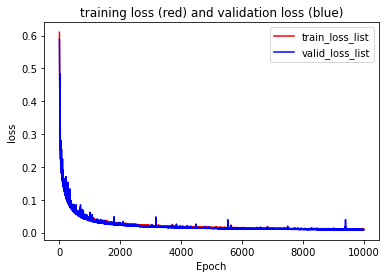

In [10]:
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label = "train_loss_list", color='r')
plt.plot(np.arange(len(valid_loss_list)), valid_loss_list, label = "valid_loss_list", color='b')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('training loss (red) and validation loss (blue)')
plt.legend()
plt.show()

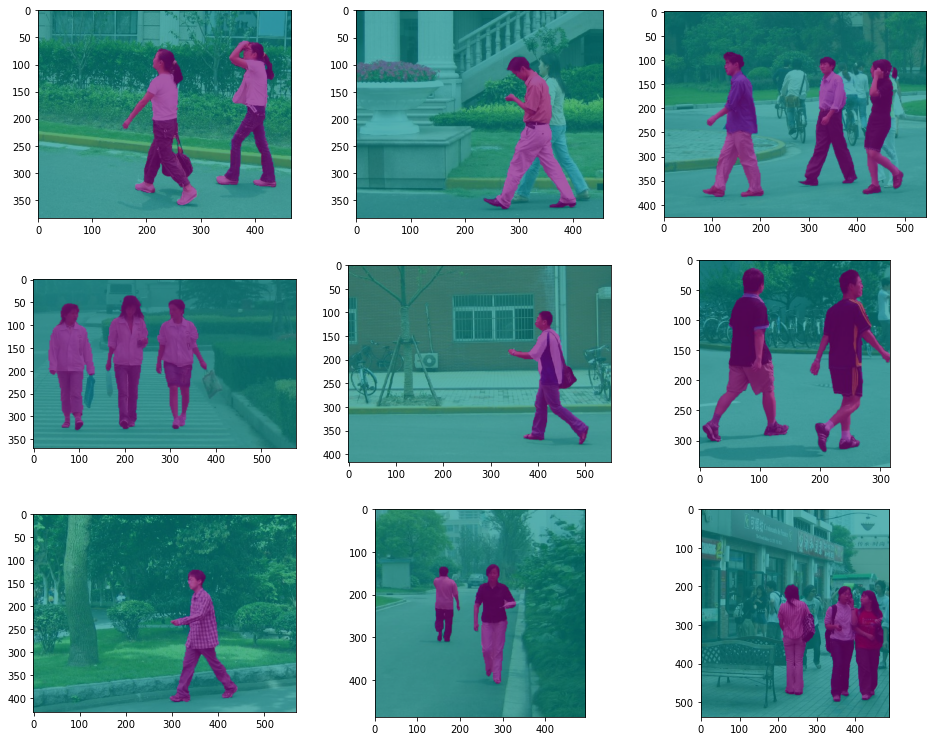

In [71]:
def predict_img(net, img, res, out_threshold=0.5):
    net.eval()
    img = cv2.resize(img, res)/255
    img = np.transpose(img, axes=[2, 0, 1])
    img = torch.from_numpy(np.array([img.tolist()])).type(torch.FloatTensor)   # Height*Width*Channel to Channel*Height*Width
    img = img.to(device)
    with torch.no_grad():
        pred = net(img)
        pred = pred.squeeze(0).squeeze(0)
        pred = torch.round(pred)
    return pred
def display(img):
    mask = predict_img(net=net,img=img,res=(256,256),out_threshold=0.5).cpu().numpy()
    mask = cv2.resize(mask,(img.shape[1],img.shape[0]))*255
    mask = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    mask_inv = cv2.bitwise_not(mask)
    mask[:,:,1] = 0
    mask_inv[:,:,0] = 0
    img_seg = cv2.addWeighted(img,0.5,mask_inv,0.5,0)
    img_seg = cv2.addWeighted(img_seg,0.7,mask,0.3,0)
    return img_seg

img_path_displays = ['./archive/PNGImages/FudanPed00012.png','./archive/PNGImages/FudanPed00014.png',
                     './archive/PNGImages/FudanPed00016.png', './archive/PNGImages/FudanPed00059.png', 
                     './archive/PNGImages/FudanPed00020.png', './archive/PNGImages/FudanPed00028.png', 
                     './archive/PNGImages/FudanPed00031.png', './archive/PNGImages/FudanPed00039.png', 
                     './archive/PNGImages/FudanPed00045.png']

plt.figure(figsize = (16,13))
plt.title('Image Segmentation Result')
for i, img_path_display in enumerate(img_path_displays):
    img = cv2.imread(img_path_display)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_seg = display(img)
    plt.subplot(3,3,i+1)
    plt.imshow(img_seg)
